This notebook looks at the random effects multinomial logistic regression. The simpleset case is just one grouping variable and three levels (2 levels would just be a binary logistic regression). The model is:

TODO: add priors and such
$$
\log \left( \frac{p_{ij}}{p_{i1}} \right) = \beta_j + u_{ij}  
$$

where $p_{ij}$ is the probability of the $j$ th outcome for the $i$ th group and $u_{ij}$ is the random effect for the $i$ th group.

The random effects are assumed to be normally distributed with mean 0 and covariance matrix $\Sigma_u$

In [3]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.special import softmax
import pymc as pm
import matplotlib.pyplot as plt
import bambi as bmb
import arviz as az
import pytensor.tensor as pt

np.random.seed(33)

# Settings
num_groups = 100
num_categories = 3  # categories: 0 (pivot), 1, 2 minimal non-trivial 
 
# mean effect is zero, but we could set it to something else
mean_effect = np.zeros(num_categories - 1)

corr_effect = np.array([
    [1.0, 0.7],
    [0.7, 1.0]
])

sds = [0.5, 1.0]

cov_effect = np.diag(sds) @ corr_effect @ np.diag(sds)

 

group_effects = multivariate_normal.rvs(mean=mean_effect, cov=cov_effect, size=num_groups)
# Add pivot logits = 0
group_effects = np.hstack([np.zeros((num_groups, 1)), group_effects])

# Store group random effects in a DataFrame
group_ids = [f'group_{i}' for i in range(num_groups)]
group_effects_df = pd.DataFrame(group_effects, columns=[f'logit_{i}' for i in range(num_categories)])
group_effects_df['group'] = group_ids

# Generate observations per group
data = []
for idx, group in enumerate(group_ids):
    n_obs = np.random.poisson(30)  #  average 30 observations per group
    
  
    logits = group_effects[idx]
    probs = softmax(logits)
    for obs in range(n_obs):
          
        observed_cat = np.random.choice(num_categories, p=probs)
        
        # Append observation
        data.append({
            'group': group,
            'group_id' : idx,
            'cat': f'cat_{observed_cat}',
            'cat_id': observed_cat,
        })

# Convert to DataFrame
simulated_df = pd.DataFrame(data)


print(simulated_df.head(10))


     group  group_id    cat  cat_id
0  group_0         0  cat_1       1
1  group_0         0  cat_2       2
2  group_0         0  cat_0       0
3  group_0         0  cat_1       1
4  group_0         0  cat_1       1
5  group_0         0  cat_2       2
6  group_0         0  cat_2       2
7  group_0         0  cat_1       1
8  group_0         0  cat_0       0
9  group_0         0  cat_1       1


In [4]:
cov_effect

array([[0.25, 0.35],
       [0.35, 1.  ]])

Check empirical covariance of logits

In [5]:
 
emp_cov = np.cov(group_effects[:,1:].T)
print(emp_cov)


[[0.25635594 0.37392667]
 [0.37392667 1.13115093]]


We can try to use bambi here, but it doesn't support correlated random effects in this case. It doesnt even estimate a different random effect for each log_odds. In BRMS we can do it with `(1|ID|group)` syntax. I dont believe bambi has a simular feature. Best we can do is to estimate uncorrelated effects.

In [6]:
 

model = bmb.Model('cat ~  (1| group)', data=simulated_df, family='categorical')
results = model.fit()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, 1|group_sigma, 1|group_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 31 seconds.


In [7]:
 
az.summary(results)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept[cat_1],-0.078,0.081,-0.223,0.077,0.002,0.001,2372.0,2643.0,1.00
Intercept[cat_2],0.102,0.079,-0.045,0.253,0.002,0.001,2381.0,2769.0,1.00
1|group_sigma,0.651,0.055,0.555,0.757,0.002,0.001,1202.0,1713.0,1.01
"1|group[cat_1, group_0]",0.172,0.359,-0.521,0.820,0.004,0.006,6905.0,2647.0,1.00
"1|group[cat_1, group_1]",0.046,0.416,-0.741,0.828,0.005,0.008,6448.0,2696.0,1.00
...,...,...,...,...,...,...,...,...,...
"1|group[cat_2, group_95]",0.751,0.338,0.146,1.416,0.004,0.006,5802.0,2818.0,1.00
"1|group[cat_2, group_96]",0.201,0.416,-0.599,0.956,0.005,0.007,5844.0,2864.0,1.00
"1|group[cat_2, group_97]",0.601,0.383,-0.133,1.301,0.005,0.006,5907.0,3232.0,1.00
"1|group[cat_2, group_98]",0.041,0.351,-0.646,0.678,0.004,0.006,6649.0,3281.0,1.00


The model we really want looks like this:

In [9]:
num_groups

100

In [8]:
# categorical model
num_obs = simulated_df.shape[0]

with pm.Model() as model:
     
    group_idx = pm.Data("group_idx", simulated_df["group_id"].values)
    cat_obs = pm.Data("cat_obs", simulated_df["cat_id"].values)
    sd_dist = pm.HalfStudentT.dist(nu=3, sigma=10)
    
    chol_cov,_, _ = pm.LKJCholeskyCov(
        "chol_cov",
        n=num_categories - 1,
        eta=1,
         sd_dist=sd_dist
    )

    z = pm.Normal(
        "z",
        0, 1,
        shape=(num_groups, num_categories - 1)
    )

    group_effects_m = pm.Deterministic(
        "group_effects",
        pt.dot(z, chol_cov.T), 
    )

    mean_effect = pm.Normal(
        "mean_effect",
        0, 1,
        shape=(num_categories - 1)
    )


    group_eff_obs = group_effects_m[group_idx, :]  # (num_obs, num_categories - 1)

    logits = pt.concatenate(
        [pt.zeros((num_obs, 1)), group_eff_obs + mean_effect],
        axis=1
    ) 

    
    pm.Categorical("obs", logit_p=logits, observed=cat_obs)

    trace = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, z, mean_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 47 seconds.


In [9]:
az.summary(trace, var_names = ["~z","~group_effects"])

c:\Users\rjljr\miniconda3\envs\multinom\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\rjljr\miniconda3\envs\multinom\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_effect[0],-0.005,0.063,-0.127,0.106,0.001,0.001,3396.0,2874.0,1.0
mean_effect[1],0.107,0.108,-0.092,0.313,0.002,0.002,3019.0,3122.0,1.0
chol_cov[0],0.402,0.072,0.264,0.537,0.002,0.001,1751.0,3022.0,1.0
chol_cov[1],0.788,0.139,0.513,1.040,0.005,0.003,943.0,1371.0,1.0
chol_cov[2],0.560,0.130,0.290,0.783,0.005,0.003,706.0,735.0,1.0
"chol_cov_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,NaN,4000.0,4000.0,NaN
"chol_cov_corr[0, 1]",0.800,0.101,0.616,0.975,0.004,0.003,667.0,773.0,1.0
"chol_cov_corr[1, 0]",0.800,0.101,0.616,0.975,0.004,0.003,667.0,773.0,1.0
"chol_cov_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,4109.0,3559.0,1.0
chol_cov_stds[0],0.402,0.072,0.264,0.537,0.002,0.001,1751.0,3022.0,1.0


In [10]:
dat = az.extract(trace, group = 'posterior', var_names = ["chol_cov_corr","chol_cov_stds"], combined = True)
corr = dat["chol_cov_corr"].values
stds = dat["chol_cov_stds"].values[:,None,:]
covariances =  corr * stds * stds.transpose(1, 0, 2) 
mean_covariance = np.mean(covariances, axis=2)

print(mean_covariance)

[[0.16707488 0.31956826]
 [0.31956826 0.97120959]]


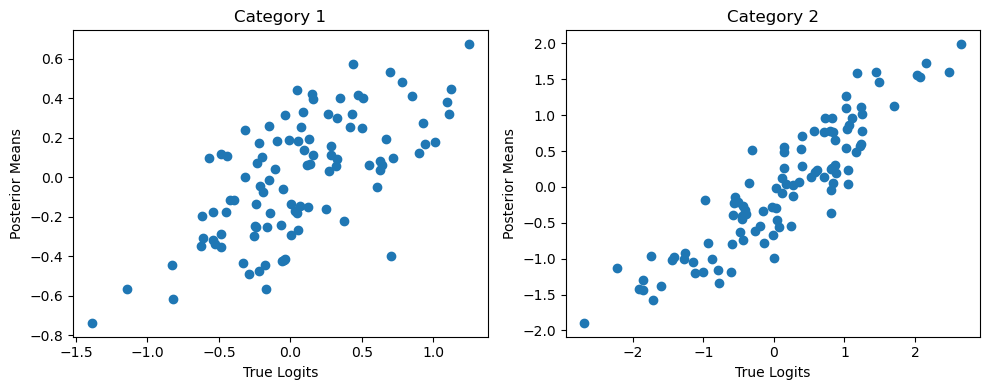

In [11]:
 
true_effects = group_effects[:, 1:]  # exclude baseline logits

 
posterior_means = trace.posterior["group_effects"].mean(dim=["chain", "draw"]).values

import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for i in range(2):
    axes[i].scatter(true_effects[:, i], posterior_means[:, i])
    axes[i].set_xlabel("True Logits")
    axes[i].set_ylabel("Posterior Means")
    axes[i].set_title(f"Category {i+1}")

plt.tight_layout()
plt.show()


## Group into aggregated data

In [15]:
agg_df = (
    simulated_df[["group_id","cat"]]
        .groupby(["group_id","cat"])
        .size()
        .reset_index()
        .pivot(index = "group_id", columns = "cat", values = 0)
        .fillna(0)
        .assign(total = lambda x:x.cat_0+ x.cat_1 + x.cat_2)
        .reset_index() # pandas please

).astype(int)
agg_df.sample(20)

cat,group_id,cat_0,cat_1,cat_2,total
28,28,15,11,14,40
50,50,8,6,3,17
3,3,9,10,14,33
98,98,10,11,12,33
89,89,11,7,7,25
90,90,14,12,7,33
6,6,9,4,16,29
59,59,0,9,19,28
5,5,8,12,13,33
76,76,14,9,2,25


Bambi doesnt yet support multinomial logistic regression at all, but we can do this in pymc.

In [16]:
 

with pm.Model() as model:
     
    group_idx = pm.Data("group_idx", agg_df["group_id"].values)
    count_obs = pm.Data("count_obs", agg_df[["cat_0","cat_1","cat_2"]].values) # 3x num_groups
    total_obs = pm.Data("total_obs", agg_df["total"].values) # num_groups


    sd_dist = pm.HalfStudentT.dist(nu=3, sigma=10)
    
    chol_cov,_, _ = pm.LKJCholeskyCov(
        "chol_cov",
        n=num_categories - 1,
        eta=1,
         sd_dist=sd_dist
    )

    z = pm.Normal(
        "z",
        0, 1,
        shape=(num_groups, num_categories - 1)
    )

    group_effects_m = pm.Deterministic(
        "group_effects",
        pt.dot(z, chol_cov.T), 
    )

    mean_effect = pm.Normal(
        "mean_effect",
        0, 1,
        shape=(num_categories - 1)
    )


    group_eff_obs = group_effects_m[group_idx, :]  # (num_groups, num_categories - 1)

    logits = pt.concatenate(
        [pt.zeros((num_groups, 1)), group_eff_obs + mean_effect],
        axis=1
    ) 

    # Pymc doesnt support logit_p in multinomial
    p = pm.math.softmax(logits, axis=1)   

    
    pm.Multinomial("obs", p=p, n=total_obs , observed=count_obs)

    trace = pm.sample()


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [chol_cov, z, mean_effect]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 24 seconds.


In [17]:
az.summary(trace, var_names = ["~z","~group_effects"])

c:\Users\rjljr\miniconda3\envs\multinom\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
c:\Users\rjljr\miniconda3\envs\multinom\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mean_effect[0],-0.007,0.064,-0.123,0.117,0.001,0.001,3301.0,3103.0,1.0
mean_effect[1],0.103,0.109,-0.103,0.306,0.002,0.002,3200.0,2313.0,1.0
chol_cov[0],0.401,0.071,0.266,0.531,0.002,0.001,1836.0,2991.0,1.0
chol_cov[1],0.777,0.134,0.525,1.026,0.004,0.002,1249.0,1821.0,1.0
chol_cov[2],0.569,0.127,0.333,0.808,0.005,0.004,832.0,878.0,1.0
"chol_cov_corr[0, 0]",1.000,0.000,1.000,1.000,0.000,NaN,4000.0,4000.0,NaN
"chol_cov_corr[0, 1]",0.793,0.098,0.608,0.967,0.003,0.002,844.0,870.0,1.0
"chol_cov_corr[1, 0]",0.793,0.098,0.608,0.967,0.003,0.002,844.0,870.0,1.0
"chol_cov_corr[1, 1]",1.000,0.000,1.000,1.000,0.000,0.000,3764.0,3714.0,1.0
chol_cov_stds[0],0.401,0.071,0.266,0.531,0.002,0.001,1836.0,2991.0,1.0


In [18]:
dat = az.extract(trace, group = 'posterior', var_names = ["chol_cov_corr","chol_cov_stds"], combined = True)
corr = dat["chol_cov_corr"].values
stds = dat["chol_cov_stds"].values[:,None,:]
covariances =  corr * stds * stds.transpose(1, 0, 2) 
mean_covariance = np.mean(covariances, axis=2)

print(mean_covariance)

[[0.16592598 0.31404016]
 [0.31404016 0.96293008]]


Posterior checking

In [20]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

In [22]:
with model:
    ppc = pm.sample_posterior_predictive(trace)


Sampling: [obs]


Output()

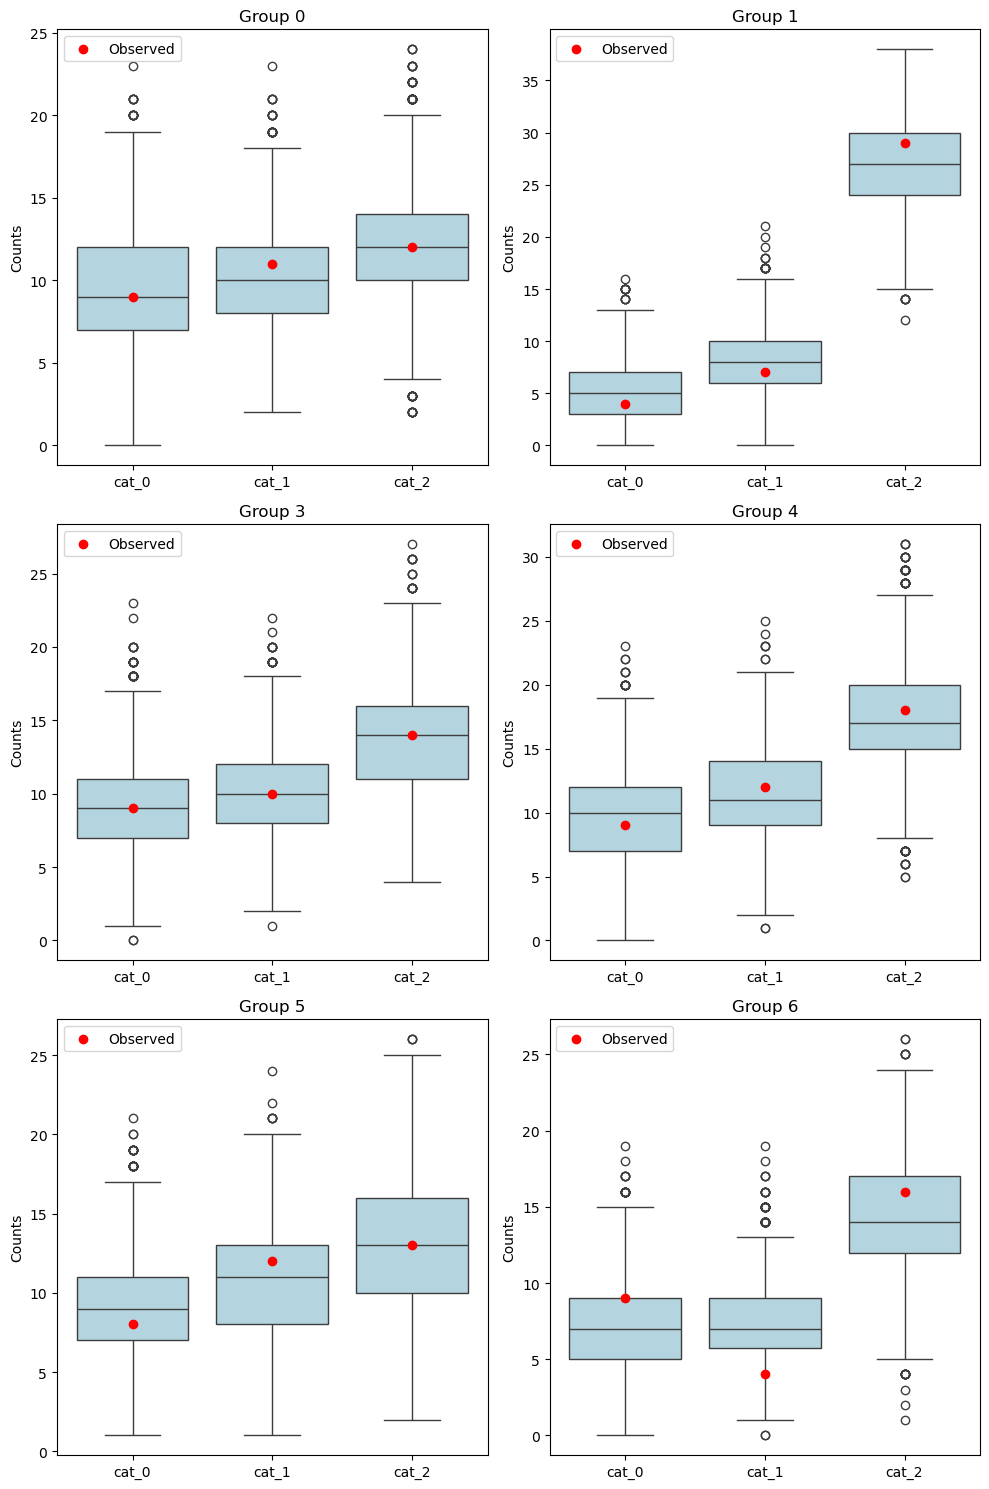

In [73]:

import seaborn as sns


selected_groups = [0, 1, 3, 4,5,6]
num_selected = len(selected_groups)

all_pp_counts = az.extract(
    ppc, group="posterior_predictive", var_names=["obs"], combined=True
)
pp_counts = all_pp_counts[selected_groups, :, :].values  # (num_groups, num_categories, num_samples)

# observed counts for comparison
obs_counts = agg_df.loc[selected_groups, ["cat_0", "cat_1", "cat_2"]].values

fig, axes = plt.subplots(num_selected // 2, 2, figsize=(10, 2.5 * num_selected))
axes = axes.flatten() if num_selected > 1 else [axes]
categories = ["cat_0", "cat_1", "cat_2"]

for idx, group in enumerate(selected_groups):
    ax = axes[idx]

    # Prepare data for seaborn boxplot
    data = [pp_counts[idx, cat_idx, :] for cat_idx in range(len(categories))]
    sns.boxplot(data=data, ax=ax, color='lightblue')

    # Overlay observed data
    ax.scatter(range(len(categories)), obs_counts[idx], color='red', zorder=5, label='Observed')
    ax.set_xticks(range(len(categories)))
    ax.set_xticklabels(categories)
    ax.set_title(f'Group {group}')
    ax.set_ylabel('Counts')
    ax.legend()

plt.tight_layout()
plt.show()
